In [1]:
%matplotlib inline
import numpy as np
import pandas as pd

import sys

from skimage.io import imread
from matplotlib import pyplot as plt

import os
os.environ['KERAS_BACKEND'] = 'theano'
os.environ['THEANO_FLAGS'] = 'mode=FAST_RUN, device=cuda, optimizer=None,exception_verbosity=high'

In [2]:
from keras import models

Using Theano backend.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Can not use cuDNN on context None: cannot compile with cuDNN. We got this error:
b'/tmp/try_flags_twbpxb6f.c:4:10: fatal error: cudnn.h: No such file or directory\n #include <cudnn.h>\n          ^~~~~~~~~\ncompilation terminated.\n'
Mapped name None to device cuda: Quadro M2000 (0000:02:00.0)


In [3]:
from keras.optimizers import SGD

In [4]:
path = './Data/'
img_w = 256
img_h = 256
n_labels = 2

n_train = 1010
n_test = 165

In [5]:
def label_map(labels):
    label_map = np.zeros([img_h, img_w, n_labels])    
    for r in range(img_h):
        for c in range(img_w):
            label_map[r, c, labels[r][c]] = 1
    return label_map

In [6]:
def prep_data(mode):
    assert mode in {'test', 'train'}, \
        'mode should be either \'test\' or \'train\''
    data = []
    label = []
    df = pd.read_csv(path + mode + '.csv')
    n = n_train if mode == 'train' else n_test
    for i, item in df.iterrows():
        if i >= n:
            break
        img, gt = [imread(path + item[0])], np.clip(imread(path + item[1]), 0, 1)
        data.append(img)
        gt2 = np.asarray(gt)
        
        label.append(label_map(gt2))
        sys.stdout.write('\r')
        sys.stdout.write(mode + ": [%-20s] %d%%" % ('=' * int(20. * (i + 1) / n - 1) + '>',
                                                    int(100. * (i + 1) / n)))
        sys.stdout.flush()
    sys.stdout.write('\r')
    sys.stdout.flush()
    data, label = np.array(data), np.array(label).reshape((n, img_h * img_w, n_labels))

    print (mode + ': OK')
    print ('\tshapes: {}, {}'.format(data.shape, label.shape))
    print ('\ttypes:  {}, {}'.format(data.dtype, label.dtype))
    print ('\tmemory: {}, {} MB'.format(data.nbytes / 1048576, label.nbytes / 1048576))

    return data, label

In [13]:
def plot_results(output):
    gt = []
    df = pd.read_csv(path + 'test.csv')
    for i, item in df.iterrows():
        gt.append(np.clip(imread(path + item[1], as_gray=True), 0, 1))

    plt.figure(figsize=(15, 2 * n_test))
    thres = 0.5
    for i, item in df.iterrows():
        plt.subplot(n_test, 4, 4 * i + 1)
        plt.title('Ground Truth')
        plt.axis('off')
        gt = imread(path + item[1], as_gray=True)
        plt.imshow(np.clip(gt, 0, 1))

        plt.subplot(n_test, 4, 4 * i + 2)
        plt.title('Prediction')
        plt.axis('off')
        labeled = np.argmax(output[i], axis=-1)
        plt.imshow(labeled)

        plt.subplot(n_test, 4, 4 * i + 3)
        plt.title('Heat map')
        plt.axis('off')
        plt.imshow(output[i][:, :, 1])

        plt.subplot(n_test, 4, 4 * i + 4)
        plt.title('Comparison')
        plt.axis('off')
        rgb = np.empty((img_h, img_w, 3))
        thresholded = labeled
        
        for i in range(0,256):
            for j in range(0,256):
                if(labeled[i][j]>thres):
                    thresholded[i][j]=1
                else:
                    thresholded[i][j]=0
        rgb[:, :, 0] = thresholded
        #print(item[0])
        
        rgb[:, :, 1] = imread(path+item[0],as_gray=True)
        rgb[:, :, 2] = gt
        plt.imshow(rgb)
        #plt.imsave(rgb, 'comparison'+ str(i)+'.png')
        

    plt.savefig('result.png')
    plt.show()

In [8]:
with open('model_5l.json') as model_file:
    autoencoder = models.model_from_json(model_file.read())

optimizer = SGD(lr=0.001, momentum=0.9, decay=0.0005, nesterov=False)
autoencoder.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])
print ('Compiled: OK')

Compiled: OK


In [10]:
train_data, train_label = prep_data('train')
nb_epoch = 50
batch_size = 2
train_data = np.reshape(train_data,(train_data.shape[0], 256, 256, 3))
history = autoencoder.fit(train_data, train_label, batch_size=batch_size, epochs=nb_epoch, verbose=1)
autoencoder.save_weights('model_5l_weight_ep501.hdf5')


train: OK==================>] 100%
	shapes: (1010, 1, 256, 256, 3), (1010, 65536, 2)
	types:  uint8, float64
	memory: 189.375, 1010.0 MB
Epoch 1/50


RuntimeError: BaseGpuCorrMM: Failed to allocate output of 2 x 64 x 256 x 256
Apply node that caused the error: GpuCorrMM{half, (1, 1), (1, 1), 1, False}(GpuContiguous.0, GpuContiguous.0)
Toposort index: 493
Inputs types: [GpuArrayType<None>(float32, 4D), GpuArrayType<None>(float32, 4D)]
Inputs shapes: [(2, 3, 256, 256), (64, 3, 3, 3)]
Inputs strides: [(786432, 262144, 1024, 4), (108, 36, 12, 4)]
Inputs values: ['not shown', 'not shown']
Inputs type_num: [11, 11]
Outputs clients: [[InplaceGpuDimShuffle{0,2,3,1}(GpuCorrMM{half, (1, 1), (1, 1), 1, False}.0)]]

Debugprint of the apply node: 
GpuCorrMM{half, (1, 1), (1, 1), 1, False} [id A] <GpuArrayType<None>(float32, 4D)> ''   
 |GpuContiguous [id B] <GpuArrayType<None>(float32, 4D)> ''   
 | |InplaceGpuDimShuffle{0,3,1,2} [id C] <GpuArrayType<None>(float32, 4D)> ''   
 |   |GpuFromHost<None> [id D] <GpuArrayType<None>(float32, 4D)> ''   
 |     |/conv2d_1_input [id E] <TensorType(float32, 4D)>
 |GpuContiguous [id F] <GpuArrayType<None>(float32, 4D)> ''   
   |GpuSubtensor{::, ::, ::int64, ::int64} [id G] <GpuArrayType<None>(float32, 4D)> ''   
     |InplaceGpuDimShuffle{3,2,0,1} [id H] <GpuArrayType<None>(float32, 4D)> ''   
     | |conv2d_1/kernel [id I] <GpuArrayType<None>(float32, 4D)>
     |Constant{-1} [id J] <int64>
     |Constant{-1} [id J] <int64>

Storage map footprint:
 - GpuElemwise{add,no_inplace}.0, Shape: (5, 256, 256, 64), ElemSize: 4 Byte(s), TotalSize: 83886080 Byte(s)
 - if{inplace,gpu}.0, Shape: (5, 256, 256, 64), ElemSize: 4 Byte(s), TotalSize: 83886080 Byte(s)
 - GpuContiguous.0, Shape: (5, 64, 256, 256), ElemSize: 4 Byte(s), TotalSize: 83886080 Byte(s)
 - GpuElemwise{add,no_inplace}.0, Shape: (5, 256, 256, 64), ElemSize: 4 Byte(s), TotalSize: 83886080 Byte(s)
 - if{inplace,gpu}.0, Shape: (5, 256, 256, 64), ElemSize: 4 Byte(s), TotalSize: 83886080 Byte(s)
 - GpuContiguous.0, Shape: (5, 64, 256, 256), ElemSize: 4 Byte(s), TotalSize: 83886080 Byte(s)
 - GpuContiguous.0, Shape: (5, 64, 256, 256), ElemSize: 4 Byte(s), TotalSize: 83886080 Byte(s)
 - GpuContiguous.0, Shape: (5, 64, 256, 256), ElemSize: 4 Byte(s), TotalSize: 83886080 Byte(s)
 - if{inplace,gpu}.0, Shape: (5, 256, 256, 64), ElemSize: 4 Byte(s), TotalSize: 83886080 Byte(s)
 - if{inplace,gpu}.0, Shape: (5, 256, 256, 64), ElemSize: 4 Byte(s), TotalSize: 83886080 Byte(s)
 - GpuElemwise{Composite{(i0 * (i1 - i2))}}[]<gpuarray>.0, Shape: (5, 256, 256, 64), ElemSize: 4 Byte(s), TotalSize: 83886080 Byte(s)
 - GpuElemwise{Sub}[(0, 0)]<gpuarray>.0, Shape: (5, 256, 256, 64), ElemSize: 4 Byte(s), TotalSize: 83886080 Byte(s)
 - GpuElemwise{Composite{((i0 * (i1 - i2)) + (i3 * i4))}}[]<gpuarray>.0, Shape: (5, 256, 256, 64), ElemSize: 4 Byte(s), TotalSize: 83886080 Byte(s)
 - GpuContiguous.0, Shape: (5, 64, 256, 256), ElemSize: 4 Byte(s), TotalSize: 83886080 Byte(s)
 - GpuAlloc<None>{memset_0=True}.0, Shape: (5, 128, 128, 128), ElemSize: 4 Byte(s), TotalSize: 41943040 Byte(s)
 - GpuAlloc<None>{memset_0=True}.0, Shape: (5, 128, 128, 128), ElemSize: 4 Byte(s), TotalSize: 41943040 Byte(s)
 - GpuElemwise{add,no_inplace}.0, Shape: (5, 128, 128, 128), ElemSize: 4 Byte(s), TotalSize: 41943040 Byte(s)
 - if{inplace,gpu}.0, Shape: (5, 128, 128, 128), ElemSize: 4 Byte(s), TotalSize: 41943040 Byte(s)
 - GpuContiguous.0, Shape: (5, 128, 128, 128), ElemSize: 4 Byte(s), TotalSize: 41943040 Byte(s)
 - GpuElemwise{add,no_inplace}.0, Shape: (5, 128, 128, 128), ElemSize: 4 Byte(s), TotalSize: 41943040 Byte(s)
 - if{inplace,gpu}.0, Shape: (5, 128, 128, 128), ElemSize: 4 Byte(s), TotalSize: 41943040 Byte(s)
 - GpuContiguous.0, Shape: (5, 128, 128, 128), ElemSize: 4 Byte(s), TotalSize: 41943040 Byte(s)
 - GpuContiguous.0, Shape: (5, 128, 128, 128), ElemSize: 4 Byte(s), TotalSize: 41943040 Byte(s)
 - GpuElemwise{sub,no_inplace}.0, Shape: (5, 128, 128, 128), ElemSize: 4 Byte(s), TotalSize: 41943040 Byte(s)
 - GpuContiguous.0, Shape: (5, 128, 128, 128), ElemSize: 4 Byte(s), TotalSize: 41943040 Byte(s)
 - if{inplace,gpu}.0, Shape: (5, 128, 128, 128), ElemSize: 4 Byte(s), TotalSize: 41943040 Byte(s)
 - GpuElemwise{Composite{(i0 * (i1 - i2))}}[(0, 1)]<gpuarray>.0, Shape: (5, 128, 128, 128), ElemSize: 4 Byte(s), TotalSize: 41943040 Byte(s)
 - GpuElemwise{Composite{((i0 * (i1 - i2)) + (i3 * i4))}}[(0, 3)]<gpuarray>.0, Shape: (5, 128, 128, 128), ElemSize: 4 Byte(s), TotalSize: 41943040 Byte(s)
 - GpuContiguous.0, Shape: (5, 128, 128, 128), ElemSize: 4 Byte(s), TotalSize: 41943040 Byte(s)
 - if{inplace,gpu}.0, Shape: (5, 128, 128, 128), ElemSize: 4 Byte(s), TotalSize: 41943040 Byte(s)
 - if{inplace,gpu}.0, Shape: (5, 128, 128, 128), ElemSize: 4 Byte(s), TotalSize: 41943040 Byte(s)
 - GpuContiguous.0, Shape: (5, 64, 128, 128), ElemSize: 4 Byte(s), TotalSize: 20971520 Byte(s)
 - GpuElemwise{add,no_inplace}.0, Shape: (5, 64, 64, 256), ElemSize: 4 Byte(s), TotalSize: 20971520 Byte(s)
 - if{inplace,gpu}.0, Shape: (5, 64, 64, 256), ElemSize: 4 Byte(s), TotalSize: 20971520 Byte(s)
 - GpuContiguous.0, Shape: (5, 256, 64, 64), ElemSize: 4 Byte(s), TotalSize: 20971520 Byte(s)
 - GpuElemwise{add,no_inplace}.0, Shape: (5, 64, 64, 256), ElemSize: 4 Byte(s), TotalSize: 20971520 Byte(s)
 - GpuElemwise{sub,no_inplace}.0, Shape: (5, 64, 64, 256), ElemSize: 4 Byte(s), TotalSize: 20971520 Byte(s)
 - GpuContiguous.0, Shape: (5, 256, 64, 64), ElemSize: 4 Byte(s), TotalSize: 20971520 Byte(s)
 - GpuElemwise{sub,no_inplace}.0, Shape: (5, 64, 64, 256), ElemSize: 4 Byte(s), TotalSize: 20971520 Byte(s)
 - GpuContiguous.0, Shape: (5, 256, 64, 64), ElemSize: 4 Byte(s), TotalSize: 20971520 Byte(s)
 - GpuElemwise{add,no_inplace}.0, Shape: (5, 64, 64, 256), ElemSize: 4 Byte(s), TotalSize: 20971520 Byte(s)
 - GpuContiguous.0, Shape: (5, 256, 64, 64), ElemSize: 4 Byte(s), TotalSize: 20971520 Byte(s)
 - GpuContiguous.0, Shape: (5, 256, 64, 64), ElemSize: 4 Byte(s), TotalSize: 20971520 Byte(s)
 - GpuElemwise{add,no_inplace}.0, Shape: (5, 128, 128, 64), ElemSize: 4 Byte(s), TotalSize: 20971520 Byte(s)
 - if{inplace,gpu}.0, Shape: (5, 128, 128, 64), ElemSize: 4 Byte(s), TotalSize: 20971520 Byte(s)
 - GpuElemwise{mul,no_inplace}.0, Shape: (5, 128, 128, 64), ElemSize: 4 Byte(s), TotalSize: 20971520 Byte(s)
 - GpuElemwise{Composite{((i0 * (i1 - i2)) + (i3 * i4))}}[]<gpuarray>.0, Shape: (5, 128, 128, 64), ElemSize: 4 Byte(s), TotalSize: 20971520 Byte(s)
 - GpuContiguous.0, Shape: (5, 64, 128, 128), ElemSize: 4 Byte(s), TotalSize: 20971520 Byte(s)
 - if{inplace,gpu}.0, Shape: (5, 64, 64, 256), ElemSize: 4 Byte(s), TotalSize: 20971520 Byte(s)
 - if{inplace,gpu}.0, Shape: (5, 64, 64, 256), ElemSize: 4 Byte(s), TotalSize: 20971520 Byte(s)
 - GpuElemwise{Composite{(i0 * (i1 - i2))}}[]<gpuarray>.0, Shape: (5, 64, 64, 256), ElemSize: 4 Byte(s), TotalSize: 20971520 Byte(s)
 - GpuElemwise{Sub}[(0, 0)]<gpuarray>.0, Shape: (5, 64, 64, 256), ElemSize: 4 Byte(s), TotalSize: 20971520 Byte(s)
 - GpuElemwise{Composite{((i0 * (i1 - i2)) + (i3 * i4))}}[]<gpuarray>.0, Shape: (5, 64, 64, 256), ElemSize: 4 Byte(s), TotalSize: 20971520 Byte(s)
 - GpuContiguous.0, Shape: (5, 256, 64, 64), ElemSize: 4 Byte(s), TotalSize: 20971520 Byte(s)
 - if{inplace,gpu}.0, Shape: (5, 64, 64, 256), ElemSize: 4 Byte(s), TotalSize: 20971520 Byte(s)
 - GpuElemwise{mul,no_inplace}.0, Shape: (5, 64, 64, 256), ElemSize: 4 Byte(s), TotalSize: 20971520 Byte(s)
 - GpuElemwise{Composite{((i0 * (i1 - i2)) + (i3 * i4))}}[]<gpuarray>.0, Shape: (5, 64, 64, 256), ElemSize: 4 Byte(s), TotalSize: 20971520 Byte(s)
 - GpuContiguous.0, Shape: (5, 256, 64, 64), ElemSize: 4 Byte(s), TotalSize: 20971520 Byte(s)
 - if{inplace,gpu}.0, Shape: (5, 64, 64, 256), ElemSize: 4 Byte(s), TotalSize: 20971520 Byte(s)
 - GpuElemwise{Composite{(i0 * (i1 - i2))}}[(0, 1)]<gpuarray>.0, Shape: (5, 64, 64, 256), ElemSize: 4 Byte(s), TotalSize: 20971520 Byte(s)
 - GpuElemwise{Composite{((i0 * (i1 - i2)) + (i3 * i4))}}[(0, 3)]<gpuarray>.0, Shape: (5, 64, 64, 256), ElemSize: 4 Byte(s), TotalSize: 20971520 Byte(s)
 - GpuContiguous.0, Shape: (5, 256, 64, 64), ElemSize: 4 Byte(s), TotalSize: 20971520 Byte(s)
 - if{inplace,gpu}.0, Shape: (5, 64, 64, 256), ElemSize: 4 Byte(s), TotalSize: 20971520 Byte(s)
 - if{inplace,gpu}.0, Shape: (5, 64, 64, 256), ElemSize: 4 Byte(s), TotalSize: 20971520 Byte(s)
 - GpuElemwise{Composite{((i0 * (i1 - i2)) + (i3 * i4))}}[]<gpuarray>.0, Shape: (5, 64, 64, 256), ElemSize: 4 Byte(s), TotalSize: 20971520 Byte(s)
 - GpuContiguous.0, Shape: (5, 256, 64, 64), ElemSize: 4 Byte(s), TotalSize: 20971520 Byte(s)
 - GpuContiguous.0, Shape: (5, 128, 64, 64), ElemSize: 4 Byte(s), TotalSize: 10485760 Byte(s)
 - GpuElemwise{add,no_inplace}.0, Shape: (5, 32, 32, 512), ElemSize: 4 Byte(s), TotalSize: 10485760 Byte(s)
 - GpuContiguous.0, Shape: (5, 512, 32, 32), ElemSize: 4 Byte(s), TotalSize: 10485760 Byte(s)
 - GpuContiguous.0, Shape: (5, 512, 32, 32), ElemSize: 4 Byte(s), TotalSize: 10485760 Byte(s)
 - GpuElemwise{add,no_inplace}.0, Shape: (5, 32, 32, 512), ElemSize: 4 Byte(s), TotalSize: 10485760 Byte(s)
 - GpuElemwise{sub,no_inplace}.0, Shape: (5, 32, 32, 512), ElemSize: 4 Byte(s), TotalSize: 10485760 Byte(s)
 - GpuContiguous.0, Shape: (5, 512, 32, 32), ElemSize: 4 Byte(s), TotalSize: 10485760 Byte(s)
 - GpuContiguous.0, Shape: (5, 512, 32, 32), ElemSize: 4 Byte(s), TotalSize: 10485760 Byte(s)
 - GpuElemwise{add,no_inplace}.0, Shape: (5, 32, 32, 512), ElemSize: 4 Byte(s), TotalSize: 10485760 Byte(s)
 - GpuElemwise{sub,no_inplace}.0, Shape: (5, 32, 32, 512), ElemSize: 4 Byte(s), TotalSize: 10485760 Byte(s)
 - GpuContiguous.0, Shape: (5, 512, 32, 32), ElemSize: 4 Byte(s), TotalSize: 10485760 Byte(s)
 - if{inplace,gpu}.0, Shape: (5, 64, 64, 128), ElemSize: 4 Byte(s), TotalSize: 10485760 Byte(s)
 - if{inplace,gpu}.0, Shape: (5, 64, 64, 128), ElemSize: 4 Byte(s), TotalSize: 10485760 Byte(s)
 - GpuElemwise{Composite{((i0 * (i1 - i2)) + (i3 * i4))}}[]<gpuarray>.0, Shape: (5, 64, 64, 128), ElemSize: 4 Byte(s), TotalSize: 10485760 Byte(s)
 - GpuContiguous.0, Shape: (5, 128, 64, 64), ElemSize: 4 Byte(s), TotalSize: 10485760 Byte(s)
 - if{inplace,gpu}.0, Shape: (5, 32, 32, 512), ElemSize: 4 Byte(s), TotalSize: 10485760 Byte(s)
 - if{inplace,gpu}.0, Shape: (5, 32, 32, 512), ElemSize: 4 Byte(s), TotalSize: 10485760 Byte(s)
 - GpuElemwise{Composite{((i0 * (i1 - i2)) + (i3 * i4))}}[]<gpuarray>.0, Shape: (5, 32, 32, 512), ElemSize: 4 Byte(s), TotalSize: 10485760 Byte(s)
 - GpuContiguous.0, Shape: (5, 512, 32, 32), ElemSize: 4 Byte(s), TotalSize: 10485760 Byte(s)
 - if{inplace,gpu}.0, Shape: (5, 32, 32, 512), ElemSize: 4 Byte(s), TotalSize: 10485760 Byte(s)
 - if{inplace,gpu}.0, Shape: (5, 32, 32, 512), ElemSize: 4 Byte(s), TotalSize: 10485760 Byte(s)
 - GpuElemwise{Composite{(i0 * (i1 - i2))}}[]<gpuarray>.0, Shape: (5, 32, 32, 512), ElemSize: 4 Byte(s), TotalSize: 10485760 Byte(s)
 - GpuElemwise{Sub}[(0, 0)]<gpuarray>.0, Shape: (5, 32, 32, 512), ElemSize: 4 Byte(s), TotalSize: 10485760 Byte(s)
 - GpuElemwise{Composite{((i0 * (i1 - i2)) + (i3 * i4))}}[]<gpuarray>.0, Shape: (5, 32, 32, 512), ElemSize: 4 Byte(s), TotalSize: 10485760 Byte(s)
 - GpuContiguous.0, Shape: (5, 512, 32, 32), ElemSize: 4 Byte(s), TotalSize: 10485760 Byte(s)
 - if{inplace,gpu}.0, Shape: (5, 32, 32, 512), ElemSize: 4 Byte(s), TotalSize: 10485760 Byte(s)
 - if{inplace,gpu}.0, Shape: (5, 32, 32, 512), ElemSize: 4 Byte(s), TotalSize: 10485760 Byte(s)
 - GpuElemwise{Composite{((i0 * (i1 - i2)) + (i3 * i4))}}[]<gpuarray>.0, Shape: (5, 32, 32, 512), ElemSize: 4 Byte(s), TotalSize: 10485760 Byte(s)
 - GpuContiguous.0, Shape: (5, 512, 32, 32), ElemSize: 4 Byte(s), TotalSize: 10485760 Byte(s)
 - if{inplace,gpu}.0, Shape: (5, 32, 32, 512), ElemSize: 4 Byte(s), TotalSize: 10485760 Byte(s)
 - if{inplace,gpu}.0, Shape: (5, 32, 32, 512), ElemSize: 4 Byte(s), TotalSize: 10485760 Byte(s)
 - GpuElemwise{Composite{(i0 * (i1 - i2))}}[]<gpuarray>.0, Shape: (5, 32, 32, 512), ElemSize: 4 Byte(s), TotalSize: 10485760 Byte(s)
 - GpuElemwise{Sub}[(0, 0)]<gpuarray>.0, Shape: (5, 32, 32, 512), ElemSize: 4 Byte(s), TotalSize: 10485760 Byte(s)
 - GpuElemwise{Composite{((i0 * (i1 - i2)) + (i3 * i4))}}[]<gpuarray>.0, Shape: (5, 32, 32, 512), ElemSize: 4 Byte(s), TotalSize: 10485760 Byte(s)
 - GpuContiguous.0, Shape: (5, 512, 32, 32), ElemSize: 4 Byte(s), TotalSize: 10485760 Byte(s)
 - if{inplace,gpu}.0, Shape: (5, 32, 32, 512), ElemSize: 4 Byte(s), TotalSize: 10485760 Byte(s)
 - GpuElemwise{mul,no_inplace}.0, Shape: (5, 32, 32, 512), ElemSize: 4 Byte(s), TotalSize: 10485760 Byte(s)
 - GpuElemwise{Composite{((i0 * (i1 - i2)) + (i3 * i4))}}[]<gpuarray>.0, Shape: (5, 32, 32, 512), ElemSize: 4 Byte(s), TotalSize: 10485760 Byte(s)
 - GpuContiguous.0, Shape: (5, 512, 32, 32), ElemSize: 4 Byte(s), TotalSize: 10485760 Byte(s)
 - conv2d_9/kernel, Shared Input, Shape: (3, 3, 512, 512), ElemSize: 4 Byte(s), TotalSize: 9437184 Byte(s)
 - conv2d_10/kernel, Shared Input, Shape: (3, 3, 512, 512), ElemSize: 4 Byte(s), TotalSize: 9437184 Byte(s)
 - conv2d_11/kernel, Shared Input, Shape: (3, 3, 512, 512), ElemSize: 4 Byte(s), TotalSize: 9437184 Byte(s)
 - conv2d_12/kernel, Shared Input, Shape: (3, 3, 512, 512), ElemSize: 4 Byte(s), TotalSize: 9437184 Byte(s)
 - conv2d_13/kernel, Shared Input, Shape: (3, 3, 512, 512), ElemSize: 4 Byte(s), TotalSize: 9437184 Byte(s)
 - conv2d_14/kernel, Shared Input, Shape: (3, 3, 512, 512), ElemSize: 4 Byte(s), TotalSize: 9437184 Byte(s)
 - conv2d_15/kernel, Shared Input, Shape: (3, 3, 512, 512), ElemSize: 4 Byte(s), TotalSize: 9437184 Byte(s)
 - conv2d_16/kernel, Shared Input, Shape: (3, 3, 512, 512), ElemSize: 4 Byte(s), TotalSize: 9437184 Byte(s)
 - conv2d_17/kernel, Shared Input, Shape: (3, 3, 512, 512), ElemSize: 4 Byte(s), TotalSize: 9437184 Byte(s)
 - conv2d_18/kernel, Shared Input, Shape: (3, 3, 512, 512), ElemSize: 4 Byte(s), TotalSize: 9437184 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (3, 3, 512, 512), ElemSize: 4 Byte(s), TotalSize: 9437184 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (3, 3, 512, 512), ElemSize: 4 Byte(s), TotalSize: 9437184 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (3, 3, 512, 512), ElemSize: 4 Byte(s), TotalSize: 9437184 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (3, 3, 512, 512), ElemSize: 4 Byte(s), TotalSize: 9437184 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (3, 3, 512, 512), ElemSize: 4 Byte(s), TotalSize: 9437184 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (3, 3, 512, 512), ElemSize: 4 Byte(s), TotalSize: 9437184 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (3, 3, 512, 512), ElemSize: 4 Byte(s), TotalSize: 9437184 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (3, 3, 512, 512), ElemSize: 4 Byte(s), TotalSize: 9437184 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (3, 3, 512, 512), ElemSize: 4 Byte(s), TotalSize: 9437184 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (3, 3, 512, 512), ElemSize: 4 Byte(s), TotalSize: 9437184 Byte(s)
 - GpuContiguous.0, Shape: (5, 256, 32, 32), ElemSize: 4 Byte(s), TotalSize: 5242880 Byte(s)
 - GpuElemwise{sub,no_inplace}.0, Shape: (5, 32, 32, 256), ElemSize: 4 Byte(s), TotalSize: 5242880 Byte(s)
 - if{inplace,gpu}.0, Shape: (5, 32, 32, 256), ElemSize: 4 Byte(s), TotalSize: 5242880 Byte(s)
 - GpuElemwise{Composite{(i0 * (i1 - i2))}}[(0, 1)]<gpuarray>.0, Shape: (5, 32, 32, 256), ElemSize: 4 Byte(s), TotalSize: 5242880 Byte(s)
 - GpuElemwise{Composite{((i0 * (i1 - i2)) + (i3 * i4))}}[(0, 3)]<gpuarray>.0, Shape: (5, 32, 32, 256), ElemSize: 4 Byte(s), TotalSize: 5242880 Byte(s)
 - GpuContiguous.0, Shape: (5, 256, 32, 32), ElemSize: 4 Byte(s), TotalSize: 5242880 Byte(s)
 - conv2d_8/kernel, Shared Input, Shape: (3, 3, 256, 512), ElemSize: 4 Byte(s), TotalSize: 4718592 Byte(s)
 - conv2d_19/kernel, Shared Input, Shape: (3, 3, 512, 256), ElemSize: 4 Byte(s), TotalSize: 4718592 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (3, 3, 256, 512), ElemSize: 4 Byte(s), TotalSize: 4718592 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (3, 3, 512, 256), ElemSize: 4 Byte(s), TotalSize: 4718592 Byte(s)
 - GpuContiguous.0, Shape: (5, 512, 16, 16), ElemSize: 4 Byte(s), TotalSize: 2621440 Byte(s)
 - GpuContiguous.0, Shape: (5, 512, 16, 16), ElemSize: 4 Byte(s), TotalSize: 2621440 Byte(s)
 - GpuElemwise{add,no_inplace}.0, Shape: (5, 16, 16, 512), ElemSize: 4 Byte(s), TotalSize: 2621440 Byte(s)
 - GpuContiguous.0, Shape: (5, 512, 16, 16), ElemSize: 4 Byte(s), TotalSize: 2621440 Byte(s)
 - GpuContiguous.0, Shape: (5, 512, 16, 16), ElemSize: 4 Byte(s), TotalSize: 2621440 Byte(s)
 - GpuElemwise{add,no_inplace}.0, Shape: (5, 16, 16, 512), ElemSize: 4 Byte(s), TotalSize: 2621440 Byte(s)
 - GpuElemwise{sub,no_inplace}.0, Shape: (5, 16, 16, 512), ElemSize: 4 Byte(s), TotalSize: 2621440 Byte(s)
 - GpuContiguous.0, Shape: (5, 512, 16, 16), ElemSize: 4 Byte(s), TotalSize: 2621440 Byte(s)
 - GpuElemwise{sub,no_inplace}.0, Shape: (5, 16, 16, 512), ElemSize: 4 Byte(s), TotalSize: 2621440 Byte(s)
 - GpuContiguous.0, Shape: (5, 512, 16, 16), ElemSize: 4 Byte(s), TotalSize: 2621440 Byte(s)
 - GpuElemwise{add,no_inplace}.0, Shape: (5, 256, 256, 2), ElemSize: 4 Byte(s), TotalSize: 2621440 Byte(s)
 - GpuElemwise{sub,no_inplace}.0, Shape: (5, 256, 256, 2), ElemSize: 4 Byte(s), TotalSize: 2621440 Byte(s)
 - if{inplace,gpu}.0, Shape: (5, 256, 256, 2), ElemSize: 4 Byte(s), TotalSize: 2621440 Byte(s)
 - if{inplace,gpu}.0, Shape: (5, 256, 256, 2), ElemSize: 4 Byte(s), TotalSize: 2621440 Byte(s)
 - GpuElemwise{Composite{((i0 * (i1 - i2)) + (i3 * i4))}}[]<gpuarray>.0, Shape: (5, 256, 256, 2), ElemSize: 4 Byte(s), TotalSize: 2621440 Byte(s)
 - GpuContiguous.0, Shape: (5, 2, 256, 256), ElemSize: 4 Byte(s), TotalSize: 2621440 Byte(s)
 - if{inplace,gpu}.0, Shape: (5, 16, 16, 512), ElemSize: 4 Byte(s), TotalSize: 2621440 Byte(s)
 - GpuElemwise{Composite{((i0 * (i1 - i2)) + (i3 * i4))}}[]<gpuarray>.0, Shape: (5, 16, 16, 512), ElemSize: 4 Byte(s), TotalSize: 2621440 Byte(s)
 - GpuContiguous.0, Shape: (5, 512, 16, 16), ElemSize: 4 Byte(s), TotalSize: 2621440 Byte(s)
 - if{inplace,gpu}.0, Shape: (5, 16, 16, 512), ElemSize: 4 Byte(s), TotalSize: 2621440 Byte(s)
 - GpuElemwise{Composite{(i0 * (i1 - i2))}}[(0, 1)]<gpuarray>.0, Shape: (5, 16, 16, 512), ElemSize: 4 Byte(s), TotalSize: 2621440 Byte(s)
 - GpuElemwise{Composite{((i0 * (i1 - i2)) + (i3 * i4))}}[(0, 3)]<gpuarray>.0, Shape: (5, 16, 16, 512), ElemSize: 4 Byte(s), TotalSize: 2621440 Byte(s)
 - GpuContiguous.0, Shape: (5, 512, 16, 16), ElemSize: 4 Byte(s), TotalSize: 2621440 Byte(s)
 - if{inplace,gpu}.0, Shape: (5, 16, 16, 512), ElemSize: 4 Byte(s), TotalSize: 2621440 Byte(s)
 - if{inplace,gpu}.0, Shape: (5, 16, 16, 512), ElemSize: 4 Byte(s), TotalSize: 2621440 Byte(s)
 - GpuElemwise{Composite{((i0 * (i1 - i2)) + (i3 * i4))}}[]<gpuarray>.0, Shape: (5, 16, 16, 512), ElemSize: 4 Byte(s), TotalSize: 2621440 Byte(s)
 - GpuContiguous.0, Shape: (5, 512, 16, 16), ElemSize: 4 Byte(s), TotalSize: 2621440 Byte(s)
 - if{inplace,gpu}.0, Shape: (5, 16, 16, 512), ElemSize: 4 Byte(s), TotalSize: 2621440 Byte(s)
 - if{inplace,gpu}.0, Shape: (5, 16, 16, 512), ElemSize: 4 Byte(s), TotalSize: 2621440 Byte(s)
 - GpuElemwise{Composite{(i0 * (i1 - i2))}}[]<gpuarray>.0, Shape: (5, 16, 16, 512), ElemSize: 4 Byte(s), TotalSize: 2621440 Byte(s)
 - GpuElemwise{Sub}[(0, 0)]<gpuarray>.0, Shape: (5, 16, 16, 512), ElemSize: 4 Byte(s), TotalSize: 2621440 Byte(s)
 - GpuElemwise{Composite{((i0 * (i1 - i2)) + (i3 * i4))}}[]<gpuarray>.0, Shape: (5, 16, 16, 512), ElemSize: 4 Byte(s), TotalSize: 2621440 Byte(s)
 - GpuContiguous.0, Shape: (5, 512, 16, 16), ElemSize: 4 Byte(s), TotalSize: 2621440 Byte(s)
 - if{inplace,gpu}.0, Shape: (5, 16, 16, 512), ElemSize: 4 Byte(s), TotalSize: 2621440 Byte(s)
 - GpuElemwise{mul,no_inplace}.0, Shape: (5, 16, 16, 512), ElemSize: 4 Byte(s), TotalSize: 2621440 Byte(s)
 - GpuElemwise{Composite{((i0 * (i1 - i2)) + (i3 * i4))}}[]<gpuarray>.0, Shape: (5, 16, 16, 512), ElemSize: 4 Byte(s), TotalSize: 2621440 Byte(s)
 - GpuContiguous.0, Shape: (5, 512, 16, 16), ElemSize: 4 Byte(s), TotalSize: 2621440 Byte(s)
 - GpuElemwise{Composite{((i0 * (i1 - i2)) + (i3 * i4))}}[(0, 3)]<gpuarray>.0, Shape: (5, 16, 16, 512), ElemSize: 4 Byte(s), TotalSize: 2621440 Byte(s)
 - GpuContiguous.0, Shape: (5, 512, 16, 16), ElemSize: 4 Byte(s), TotalSize: 2621440 Byte(s)
 - conv2d_6/kernel, Shared Input, Shape: (3, 3, 256, 256), ElemSize: 4 Byte(s), TotalSize: 2359296 Byte(s)
 - conv2d_7/kernel, Shared Input, Shape: (3, 3, 256, 256), ElemSize: 4 Byte(s), TotalSize: 2359296 Byte(s)
 - conv2d_20/kernel, Shared Input, Shape: (3, 3, 256, 256), ElemSize: 4 Byte(s), TotalSize: 2359296 Byte(s)
 - conv2d_21/kernel, Shared Input, Shape: (3, 3, 256, 256), ElemSize: 4 Byte(s), TotalSize: 2359296 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (3, 3, 256, 256), ElemSize: 4 Byte(s), TotalSize: 2359296 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (3, 3, 256, 256), ElemSize: 4 Byte(s), TotalSize: 2359296 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (3, 3, 256, 256), ElemSize: 4 Byte(s), TotalSize: 2359296 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (3, 3, 256, 256), ElemSize: 4 Byte(s), TotalSize: 2359296 Byte(s)
 - /conv2d_1_input, Input, Shape: (2, 256, 256, 3), ElemSize: 4 Byte(s), TotalSize: 1572864 Byte(s)
 - GpuContiguous.0, Shape: (2, 3, 256, 256), ElemSize: 4 Byte(s), TotalSize: 1572864 Byte(s)
 - conv2d_5/kernel, Shared Input, Shape: (3, 3, 128, 256), ElemSize: 4 Byte(s), TotalSize: 1179648 Byte(s)
 - conv2d_22/kernel, Shared Input, Shape: (3, 3, 256, 128), ElemSize: 4 Byte(s), TotalSize: 1179648 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (3, 3, 128, 256), ElemSize: 4 Byte(s), TotalSize: 1179648 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (3, 3, 256, 128), ElemSize: 4 Byte(s), TotalSize: 1179648 Byte(s)
 - /activation_26_target, Input, Shape: (2, 65536, 2), ElemSize: 4 Byte(s), TotalSize: 1048576 Byte(s)
 - conv2d_4/kernel, Shared Input, Shape: (3, 3, 128, 128), ElemSize: 4 Byte(s), TotalSize: 589824 Byte(s)
 - conv2d_23/kernel, Shared Input, Shape: (3, 3, 128, 128), ElemSize: 4 Byte(s), TotalSize: 589824 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (3, 3, 128, 128), ElemSize: 4 Byte(s), TotalSize: 589824 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (3, 3, 128, 128), ElemSize: 4 Byte(s), TotalSize: 589824 Byte(s)
 - GpuContiguous.0, Shape: (128, 128, 3, 3), ElemSize: 4 Byte(s), TotalSize: 589824 Byte(s)
 - conv2d_3/kernel, Shared Input, Shape: (3, 3, 64, 128), ElemSize: 4 Byte(s), TotalSize: 294912 Byte(s)
 - conv2d_24/kernel, Shared Input, Shape: (3, 3, 128, 64), ElemSize: 4 Byte(s), TotalSize: 294912 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (3, 3, 64, 128), ElemSize: 4 Byte(s), TotalSize: 294912 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (3, 3, 128, 64), ElemSize: 4 Byte(s), TotalSize: 294912 Byte(s)
 - conv2d_2/kernel, Shared Input, Shape: (3, 3, 64, 64), ElemSize: 4 Byte(s), TotalSize: 147456 Byte(s)
 - conv2d_25/kernel, Shared Input, Shape: (3, 3, 64, 64), ElemSize: 4 Byte(s), TotalSize: 147456 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (3, 3, 64, 64), ElemSize: 4 Byte(s), TotalSize: 147456 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (3, 3, 64, 64), ElemSize: 4 Byte(s), TotalSize: 147456 Byte(s)
 - conv2d_1/kernel, Shared Input, Shape: (3, 3, 3, 64), ElemSize: 4 Byte(s), TotalSize: 6912 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (3, 3, 3, 64), ElemSize: 4 Byte(s), TotalSize: 6912 Byte(s)
 - GpuContiguous.0, Shape: (64, 3, 3, 3), ElemSize: 4 Byte(s), TotalSize: 6912 Byte(s)
 - conv2d_8/bias, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - batch_normalization_8/gamma, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - batch_normalization_8/beta, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - batch_normalization_8/moving_mean, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - batch_normalization_8/moving_variance, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - conv2d_9/bias, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - batch_normalization_9/gamma, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - batch_normalization_9/beta, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - batch_normalization_9/moving_mean, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - batch_normalization_9/moving_variance, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - conv2d_10/bias, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - batch_normalization_10/gamma, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - batch_normalization_10/beta, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - batch_normalization_10/moving_mean, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - batch_normalization_10/moving_variance, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - conv2d_11/bias, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - batch_normalization_11/gamma, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - batch_normalization_11/beta, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - batch_normalization_11/moving_mean, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - batch_normalization_11/moving_variance, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - conv2d_12/bias, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - batch_normalization_12/gamma, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - batch_normalization_12/beta, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - batch_normalization_12/moving_mean, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - batch_normalization_12/moving_variance, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - conv2d_13/bias, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - batch_normalization_13/gamma, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - batch_normalization_13/beta, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - batch_normalization_13/moving_mean, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - batch_normalization_13/moving_variance, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - conv2d_14/bias, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - batch_normalization_14/gamma, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - batch_normalization_14/beta, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - batch_normalization_14/moving_mean, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - batch_normalization_14/moving_variance, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - conv2d_15/bias, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - batch_normalization_15/gamma, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - batch_normalization_15/beta, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - batch_normalization_15/moving_mean, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - batch_normalization_15/moving_variance, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - conv2d_16/bias, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - batch_normalization_16/gamma, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - batch_normalization_16/beta, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - batch_normalization_16/moving_mean, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - batch_normalization_16/moving_variance, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - conv2d_17/bias, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - batch_normalization_17/gamma, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - batch_normalization_17/beta, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - batch_normalization_17/moving_mean, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - batch_normalization_17/moving_variance, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - conv2d_18/bias, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - batch_normalization_18/gamma, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - batch_normalization_18/beta, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - batch_normalization_18/moving_mean, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - batch_normalization_18/moving_variance, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - InplaceGpuDimShuffle{x,x,x,0}.0, Shape: (1, 1, 1, 512), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - InplaceGpuDimShuffle{x,x,x,0}.0, Shape: (1, 1, 1, 512), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - InplaceGpuDimShuffle{x,x,x,0}.0, Shape: (1, 1, 1, 512), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - InplaceGpuDimShuffle{x,x,x,0}.0, Shape: (1, 1, 1, 512), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - InplaceGpuDimShuffle{x,x,x,0}.0, Shape: (1, 1, 1, 512), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - InplaceGpuDimShuffle{x,x,x,0}.0, Shape: (1, 1, 1, 512), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - InplaceGpuDimShuffle{x,x,x,0}.0, Shape: (1, 1, 1, 512), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - InplaceGpuDimShuffle{x,x,x,0}.0, Shape: (1, 1, 1, 512), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - InplaceGpuDimShuffle{x,x,x,0}.0, Shape: (1, 1, 1, 512), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - InplaceGpuDimShuffle{x,x,x,0}.0, Shape: (1, 1, 1, 512), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - InplaceGpuDimShuffle{x,x,x,0}.0, Shape: (1, 1, 1, 512), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - InplaceGpuDimShuffle{x,x,x,0}.0, Shape: (1, 1, 1, 512), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - InplaceGpuDimShuffle{x,x,x,0}.0, Shape: (1, 1, 1, 512), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - InplaceGpuDimShuffle{x,x,x,0}.0, Shape: (1, 1, 1, 512), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - InplaceGpuDimShuffle{x,x,x,0}.0, Shape: (1, 1, 1, 512), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - InplaceGpuDimShuffle{x,x,x,0}.0, Shape: (1, 1, 1, 512), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - InplaceGpuDimShuffle{x,x,x,0}.0, Shape: (1, 1, 1, 512), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - InplaceGpuDimShuffle{x,x,x,0}.0, Shape: (1, 1, 1, 512), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - GpuElemwise{Composite{sqrt((i0 + i1))}}[]<gpuarray>.0, Shape: (1, 1, 1, 512), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - GpuElemwise{Composite{sqrt((i0 + i1))}}[]<gpuarray>.0, Shape: (1, 1, 1, 512), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - GpuElemwise{Composite{sqrt((i0 + i1))}}[]<gpuarray>.0, Shape: (1, 1, 1, 512), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - GpuElemwise{Composite{sqrt((i0 + i1))}}[]<gpuarray>.0, Shape: (1, 1, 1, 512), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - GpuElemwise{Composite{sqrt((i0 + i1))}}[]<gpuarray>.0, Shape: (1, 1, 1, 512), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - GpuElemwise{Composite{sqrt((i0 + i1))}}[]<gpuarray>.0, Shape: (1, 1, 1, 512), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - GpuElemwise{Composite{sqrt((i0 + i1))}}[]<gpuarray>.0, Shape: (1, 1, 1, 512), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - GpuElemwise{Composite{sqrt((i0 + i1))}}[]<gpuarray>.0, Shape: (1, 1, 1, 512), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - GpuElemwise{Composite{sqrt((i0 + i1))}}[]<gpuarray>.0, Shape: (1, 1, 1, 512), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - GpuElemwise{Composite{(((i0 / i1) / i2) / i3)}}[]<gpuarray>.0, Shape: (1, 1, 1, 512), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - GpuElemwise{Composite{inv(sqrt(((((i0 / i1) / i2) / i3) + i4)))}}[]<gpuarray>.0, Shape: (1, 1, 1, 512), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - GpuElemwise{Composite{(((i0 / i1) / i2) / i3)}}[]<gpuarray>.0, Shape: (1, 1, 1, 512), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - GpuElemwise{Composite{(((i0 / i1) / i2) / i3)}}[]<gpuarray>.0, Shape: (1, 1, 1, 512), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - GpuElemwise{Composite{inv(sqrt(((((i0 / i1) / i2) / i3) + i4)))}}[]<gpuarray>.0, Shape: (1, 1, 1, 512), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - GpuElemwise{Composite{(((i0 / i1) / i2) / i3)}}[]<gpuarray>.0, Shape: (1, 1, 1, 512), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - GpuElemwise{Composite{inv(sqrt(((((i0 / i1) / i2) / i3) + i4)))}}[(0, 0)]<gpuarray>.0, Shape: (1, 1, 1, 512), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - GpuElemwise{Composite{(((i0 / i1) / i2) / i3)}}[]<gpuarray>.0, Shape: (1, 1, 1, 512), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - GpuElemwise{Composite{inv(sqrt(((((i0 / i1) / i2) / i3) + i4)))}}[]<gpuarray>.0, Shape: (1, 1, 1, 512), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - GpuElemwise{Composite{inv(sqrt(((((i0 / i1) / i2) / i3) + i4)))}}[(0, 0)]<gpuarray>.0, Shape: (1, 1, 1, 512), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - GpuElemwise{Composite{(((i0 / i1) / i2) / i3)}}[]<gpuarray>.0, Shape: (1, 1, 1, 512), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - GpuElemwise{Composite{inv(sqrt(((((i0 / i1) / i2) / i3) + i4)))}}[]<gpuarray>.0, Shape: (1, 1, 1, 512), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - GpuElemwise{Composite{(((i0 / i1) / i2) / i3)}}[]<gpuarray>.0, Shape: (1, 1, 1, 512), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - GpuElemwise{Composite{inv(sqrt(((((i0 / i1) / i2) / i3) + i4)))}}[(0, 0)]<gpuarray>.0, Shape: (1, 1, 1, 512), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - GpuElemwise{Composite{(((i0 / i1) / i2) / i3)}}[]<gpuarray>.0, Shape: (1, 1, 1, 512), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - GpuElemwise{Composite{inv(sqrt(((((i0 / i1) / i2) / i3) + i4)))}}[]<gpuarray>.0, Shape: (1, 1, 1, 512), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - GpuElemwise{Composite{(((i0 / i1) / i2) / i3)}}[]<gpuarray>.0, Shape: (1, 1, 1, 512), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - GpuElemwise{Composite{inv(sqrt(((((i0 / i1) / i2) / i3) + i4)))}}[(0, 0)]<gpuarray>.0, Shape: (1, 1, 1, 512), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - GpuElemwise{Composite{(((i0 / i1) / i2) / i3)}}[]<gpuarray>.0, Shape: (1, 1, 1, 512), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - GpuElemwise{Composite{inv(sqrt(((((i0 / i1) / i2) / i3) + i4)))}}[]<gpuarray>.0, Shape: (1, 1, 1, 512), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - GpuCAReduceCuda{add}{0}.0, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - GpuCAReduceCuda{add}{0}.0, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - GpuCAReduceCuda{add}{0}.0, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - GpuCAReduceCuda{add}{0}.0, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - GpuCAReduceCuda{add}{0}.0, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - GpuCAReduceCuda{add}{0}.0, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - conv2d_5/bias, Shared Input, Shape: (256,), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - batch_normalization_5/gamma, Shared Input, Shape: (256,), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - batch_normalization_5/beta, Shared Input, Shape: (256,), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - batch_normalization_5/moving_mean, Shared Input, Shape: (256,), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - batch_normalization_5/moving_variance, Shared Input, Shape: (256,), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - conv2d_6/bias, Shared Input, Shape: (256,), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - batch_normalization_6/gamma, Shared Input, Shape: (256,), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - batch_normalization_6/beta, Shared Input, Shape: (256,), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - batch_normalization_6/moving_mean, Shared Input, Shape: (256,), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - batch_normalization_6/moving_variance, Shared Input, Shape: (256,), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - conv2d_7/bias, Shared Input, Shape: (256,), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - batch_normalization_7/gamma, Shared Input, Shape: (256,), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - batch_normalization_7/beta, Shared Input, Shape: (256,), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - batch_normalization_7/moving_mean, Shared Input, Shape: (256,), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - batch_normalization_7/moving_variance, Shared Input, Shape: (256,), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - conv2d_19/bias, Shared Input, Shape: (256,), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - batch_normalization_19/gamma, Shared Input, Shape: (256,), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - batch_normalization_19/beta, Shared Input, Shape: (256,), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - batch_normalization_19/moving_mean, Shared Input, Shape: (256,), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - batch_normalization_19/moving_variance, Shared Input, Shape: (256,), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - conv2d_20/bias, Shared Input, Shape: (256,), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - batch_normalization_20/gamma, Shared Input, Shape: (256,), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - batch_normalization_20/beta, Shared Input, Shape: (256,), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - batch_normalization_20/moving_mean, Shared Input, Shape: (256,), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - batch_normalization_20/moving_variance, Shared Input, Shape: (256,), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - conv2d_21/bias, Shared Input, Shape: (256,), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - batch_normalization_21/gamma, Shared Input, Shape: (256,), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - batch_normalization_21/beta, Shared Input, Shape: (256,), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - batch_normalization_21/moving_mean, Shared Input, Shape: (256,), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - batch_normalization_21/moving_variance, Shared Input, Shape: (256,), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (256,), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (256,), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (256,), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (256,), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (256,), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (256,), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (256,), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (256,), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (256,), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (256,), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (256,), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (256,), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (256,), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (256,), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (256,), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (256,), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (256,), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (256,), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - InplaceGpuDimShuffle{x,x,x,0}.0, Shape: (1, 1, 1, 256), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - InplaceGpuDimShuffle{x,x,x,0}.0, Shape: (1, 1, 1, 256), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - InplaceGpuDimShuffle{x,x,x,0}.0, Shape: (1, 1, 1, 256), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - InplaceGpuDimShuffle{x,x,x,0}.0, Shape: (1, 1, 1, 256), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - InplaceGpuDimShuffle{x,x,x,0}.0, Shape: (1, 1, 1, 256), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - InplaceGpuDimShuffle{x,x,x,0}.0, Shape: (1, 1, 1, 256), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - InplaceGpuDimShuffle{x,x,x,0}.0, Shape: (1, 1, 1, 256), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - InplaceGpuDimShuffle{x,x,x,0}.0, Shape: (1, 1, 1, 256), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - GpuElemwise{Composite{sqrt((i0 + i1))}}[]<gpuarray>.0, Shape: (1, 1, 1, 256), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - GpuElemwise{Composite{sqrt((i0 + i1))}}[]<gpuarray>.0, Shape: (1, 1, 1, 256), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - GpuElemwise{Composite{sqrt((i0 + i1))}}[]<gpuarray>.0, Shape: (1, 1, 1, 256), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - GpuElemwise{Composite{sqrt((i0 + i1))}}[]<gpuarray>.0, Shape: (1, 1, 1, 256), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - GpuElemwise{Composite{sqrt((i0 + i1))}}[]<gpuarray>.0, Shape: (1, 1, 1, 256), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - GpuElemwise{Composite{(((i0 / i1) / i2) / i3)}}[]<gpuarray>.0, Shape: (1, 1, 1, 256), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - GpuElemwise{Composite{inv(sqrt(((((i0 / i1) / i2) / i3) + i4)))}}[(0, 0)]<gpuarray>.0, Shape: (1, 1, 1, 256), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - GpuElemwise{Composite{(((i0 / i1) / i2) / i3)}}[]<gpuarray>.0, Shape: (1, 1, 1, 256), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - GpuElemwise{Composite{inv(sqrt(((((i0 / i1) / i2) / i3) + i4)))}}[]<gpuarray>.0, Shape: (1, 1, 1, 256), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - GpuElemwise{Composite{(((i0 / i1) / i2) / i3)}}[]<gpuarray>.0, Shape: (1, 1, 1, 256), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - GpuElemwise{Composite{inv(sqrt(((((i0 / i1) / i2) / i3) + i4)))}}[(0, 0)]<gpuarray>.0, Shape: (1, 1, 1, 256), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - GpuElemwise{Composite{(((i0 / i1) / i2) / i3)}}[]<gpuarray>.0, Shape: (1, 1, 1, 256), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - GpuElemwise{Composite{inv(sqrt(((((i0 / i1) / i2) / i3) + i4)))}}[(0, 0)]<gpuarray>.0, Shape: (1, 1, 1, 256), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - GpuElemwise{Composite{(((i0 / i1) / i2) / i3)}}[]<gpuarray>.0, Shape: (1, 1, 1, 256), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - GpuElemwise{Composite{inv(sqrt(((((i0 / i1) / i2) / i3) + i4)))}}[]<gpuarray>.0, Shape: (1, 1, 1, 256), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - GpuElemwise{Composite{(((i0 / i1) / i2) / i3)}}[]<gpuarray>.0, Shape: (1, 1, 1, 256), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - GpuElemwise{Composite{inv(sqrt(((((i0 / i1) / i2) / i3) + i4)))}}[(0, 0)]<gpuarray>.0, Shape: (1, 1, 1, 256), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - GpuCAReduceCuda{add}{0}.0, Shape: (256,), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - GpuCAReduceCuda{add}{0}.0, Shape: (256,), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - GpuCAReduceCuda{add}{0}.0, Shape: (256,), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - conv2d_3/bias, Shared Input, Shape: (128,), ElemSize: 4 Byte(s), TotalSize: 512 Byte(s)
 - batch_normalization_3/gamma, Shared Input, Shape: (128,), ElemSize: 4 Byte(s), TotalSize: 512 Byte(s)
 - batch_normalization_3/beta, Shared Input, Shape: (128,), ElemSize: 4 Byte(s), TotalSize: 512 Byte(s)
 - batch_normalization_3/moving_mean, Shared Input, Shape: (128,), ElemSize: 4 Byte(s), TotalSize: 512 Byte(s)
 - batch_normalization_3/moving_variance, Shared Input, Shape: (128,), ElemSize: 4 Byte(s), TotalSize: 512 Byte(s)
 - conv2d_4/bias, Shared Input, Shape: (128,), ElemSize: 4 Byte(s), TotalSize: 512 Byte(s)
 - batch_normalization_4/gamma, Shared Input, Shape: (128,), ElemSize: 4 Byte(s), TotalSize: 512 Byte(s)
 - batch_normalization_4/beta, Shared Input, Shape: (128,), ElemSize: 4 Byte(s), TotalSize: 512 Byte(s)
 - batch_normalization_4/moving_mean, Shared Input, Shape: (128,), ElemSize: 4 Byte(s), TotalSize: 512 Byte(s)
 - batch_normalization_4/moving_variance, Shared Input, Shape: (128,), ElemSize: 4 Byte(s), TotalSize: 512 Byte(s)
 - conv2d_22/bias, Shared Input, Shape: (128,), ElemSize: 4 Byte(s), TotalSize: 512 Byte(s)
 - batch_normalization_22/gamma, Shared Input, Shape: (128,), ElemSize: 4 Byte(s), TotalSize: 512 Byte(s)
 - batch_normalization_22/beta, Shared Input, Shape: (128,), ElemSize: 4 Byte(s), TotalSize: 512 Byte(s)
 - batch_normalization_22/moving_mean, Shared Input, Shape: (128,), ElemSize: 4 Byte(s), TotalSize: 512 Byte(s)
 - batch_normalization_22/moving_variance, Shared Input, Shape: (128,), ElemSize: 4 Byte(s), TotalSize: 512 Byte(s)
 - conv2d_23/bias, Shared Input, Shape: (128,), ElemSize: 4 Byte(s), TotalSize: 512 Byte(s)
 - batch_normalization_23/gamma, Shared Input, Shape: (128,), ElemSize: 4 Byte(s), TotalSize: 512 Byte(s)
 - batch_normalization_23/beta, Shared Input, Shape: (128,), ElemSize: 4 Byte(s), TotalSize: 512 Byte(s)
 - batch_normalization_23/moving_mean, Shared Input, Shape: (128,), ElemSize: 4 Byte(s), TotalSize: 512 Byte(s)
 - batch_normalization_23/moving_variance, Shared Input, Shape: (128,), ElemSize: 4 Byte(s), TotalSize: 512 Byte(s)
 - conv2d_26/kernel, Shared Input, Shape: (1, 1, 64, 2), ElemSize: 4 Byte(s), TotalSize: 512 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (128,), ElemSize: 4 Byte(s), TotalSize: 512 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (128,), ElemSize: 4 Byte(s), TotalSize: 512 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (128,), ElemSize: 4 Byte(s), TotalSize: 512 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (128,), ElemSize: 4 Byte(s), TotalSize: 512 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (128,), ElemSize: 4 Byte(s), TotalSize: 512 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (128,), ElemSize: 4 Byte(s), TotalSize: 512 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (128,), ElemSize: 4 Byte(s), TotalSize: 512 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (128,), ElemSize: 4 Byte(s), TotalSize: 512 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (128,), ElemSize: 4 Byte(s), TotalSize: 512 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (128,), ElemSize: 4 Byte(s), TotalSize: 512 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (128,), ElemSize: 4 Byte(s), TotalSize: 512 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (128,), ElemSize: 4 Byte(s), TotalSize: 512 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (1, 1, 64, 2), ElemSize: 4 Byte(s), TotalSize: 512 Byte(s)
 - GpuElemwise{Composite{sqrt((i0 + i1))}}[]<gpuarray>.0, Shape: (1, 1, 1, 128), ElemSize: 4 Byte(s), TotalSize: 512 Byte(s)
 - GpuElemwise{Composite{(((i0 / i1) / i2) / i3)}}[]<gpuarray>.0, Shape: (1, 1, 1, 128), ElemSize: 4 Byte(s), TotalSize: 512 Byte(s)
 - GpuElemwise{Composite{inv(sqrt(((((i0 / i1) / i2) / i3) + i4)))}}[(0, 0)]<gpuarray>.0, Shape: (1, 1, 1, 128), ElemSize: 4 Byte(s), TotalSize: 512 Byte(s)
 - GpuElemwise{Composite{(((i0 / i1) / i2) / i3)}}[]<gpuarray>.0, Shape: (1, 1, 1, 128), ElemSize: 4 Byte(s), TotalSize: 512 Byte(s)
 - GpuElemwise{Composite{inv(sqrt(((((i0 / i1) / i2) / i3) + i4)))}}[]<gpuarray>.0, Shape: (1, 1, 1, 128), ElemSize: 4 Byte(s), TotalSize: 512 Byte(s)
 - GpuElemwise{Composite{(((i0 / i1) / i2) / i3)}}[]<gpuarray>.0, Shape: (1, 1, 1, 128), ElemSize: 4 Byte(s), TotalSize: 512 Byte(s)
 - GpuElemwise{Composite{inv(sqrt(((((i0 / i1) / i2) / i3) + i4)))}}[]<gpuarray>.0, Shape: (1, 1, 1, 128), ElemSize: 4 Byte(s), TotalSize: 512 Byte(s)
 - GpuElemwise{Composite{(((i0 / i1) / i2) / i3)}}[]<gpuarray>.0, Shape: (1, 1, 1, 128), ElemSize: 4 Byte(s), TotalSize: 512 Byte(s)
 - GpuElemwise{Composite{inv(sqrt(((((i0 / i1) / i2) / i3) + i4)))}}[(0, 0)]<gpuarray>.0, Shape: (1, 1, 1, 128), ElemSize: 4 Byte(s), TotalSize: 512 Byte(s)
 - GpuCAReduceCuda{add}{0}.0, Shape: (128,), ElemSize: 4 Byte(s), TotalSize: 512 Byte(s)
 - conv2d_1/bias, Shared Input, Shape: (64,), ElemSize: 4 Byte(s), TotalSize: 256 Byte(s)
 - batch_normalization_1/gamma, Shared Input, Shape: (64,), ElemSize: 4 Byte(s), TotalSize: 256 Byte(s)
 - batch_normalization_1/beta, Shared Input, Shape: (64,), ElemSize: 4 Byte(s), TotalSize: 256 Byte(s)
 - batch_normalization_1/moving_mean, Shared Input, Shape: (64,), ElemSize: 4 Byte(s), TotalSize: 256 Byte(s)
 - batch_normalization_1/moving_variance, Shared Input, Shape: (64,), ElemSize: 4 Byte(s), TotalSize: 256 Byte(s)
 - conv2d_2/bias, Shared Input, Shape: (64,), ElemSize: 4 Byte(s), TotalSize: 256 Byte(s)
 - batch_normalization_2/gamma, Shared Input, Shape: (64,), ElemSize: 4 Byte(s), TotalSize: 256 Byte(s)
 - batch_normalization_2/beta, Shared Input, Shape: (64,), ElemSize: 4 Byte(s), TotalSize: 256 Byte(s)
 - batch_normalization_2/moving_mean, Shared Input, Shape: (64,), ElemSize: 4 Byte(s), TotalSize: 256 Byte(s)
 - batch_normalization_2/moving_variance, Shared Input, Shape: (64,), ElemSize: 4 Byte(s), TotalSize: 256 Byte(s)
 - conv2d_24/bias, Shared Input, Shape: (64,), ElemSize: 4 Byte(s), TotalSize: 256 Byte(s)
 - batch_normalization_24/gamma, Shared Input, Shape: (64,), ElemSize: 4 Byte(s), TotalSize: 256 Byte(s)
 - batch_normalization_24/beta, Shared Input, Shape: (64,), ElemSize: 4 Byte(s), TotalSize: 256 Byte(s)
 - batch_normalization_24/moving_mean, Shared Input, Shape: (64,), ElemSize: 4 Byte(s), TotalSize: 256 Byte(s)
 - batch_normalization_24/moving_variance, Shared Input, Shape: (64,), ElemSize: 4 Byte(s), TotalSize: 256 Byte(s)
 - conv2d_25/bias, Shared Input, Shape: (64,), ElemSize: 4 Byte(s), TotalSize: 256 Byte(s)
 - batch_normalization_25/gamma, Shared Input, Shape: (64,), ElemSize: 4 Byte(s), TotalSize: 256 Byte(s)
 - batch_normalization_25/beta, Shared Input, Shape: (64,), ElemSize: 4 Byte(s), TotalSize: 256 Byte(s)
 - batch_normalization_25/moving_mean, Shared Input, Shape: (64,), ElemSize: 4 Byte(s), TotalSize: 256 Byte(s)
 - batch_normalization_25/moving_variance, Shared Input, Shape: (64,), ElemSize: 4 Byte(s), TotalSize: 256 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (64,), ElemSize: 4 Byte(s), TotalSize: 256 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (64,), ElemSize: 4 Byte(s), TotalSize: 256 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (64,), ElemSize: 4 Byte(s), TotalSize: 256 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (64,), ElemSize: 4 Byte(s), TotalSize: 256 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (64,), ElemSize: 4 Byte(s), TotalSize: 256 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (64,), ElemSize: 4 Byte(s), TotalSize: 256 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (64,), ElemSize: 4 Byte(s), TotalSize: 256 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (64,), ElemSize: 4 Byte(s), TotalSize: 256 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (64,), ElemSize: 4 Byte(s), TotalSize: 256 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (64,), ElemSize: 4 Byte(s), TotalSize: 256 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (64,), ElemSize: 4 Byte(s), TotalSize: 256 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (64,), ElemSize: 4 Byte(s), TotalSize: 256 Byte(s)
 - InplaceGpuDimShuffle{x,x,x,0}.0, Shape: (1, 1, 1, 64), ElemSize: 4 Byte(s), TotalSize: 256 Byte(s)
 - InplaceGpuDimShuffle{x,x,x,0}.0, Shape: (1, 1, 1, 64), ElemSize: 4 Byte(s), TotalSize: 256 Byte(s)
 - InplaceGpuDimShuffle{x,x,x,0}.0, Shape: (1, 1, 1, 64), ElemSize: 4 Byte(s), TotalSize: 256 Byte(s)
 - InplaceGpuDimShuffle{x,x,x,0}.0, Shape: (1, 1, 1, 64), ElemSize: 4 Byte(s), TotalSize: 256 Byte(s)
 - GpuElemwise{Composite{sqrt((i0 + i1))}}[]<gpuarray>.0, Shape: (1, 1, 1, 64), ElemSize: 4 Byte(s), TotalSize: 256 Byte(s)
 - GpuElemwise{Composite{sqrt((i0 + i1))}}[]<gpuarray>.0, Shape: (1, 1, 1, 64), ElemSize: 4 Byte(s), TotalSize: 256 Byte(s)
 - GpuElemwise{Composite{(((i0 / i1) / i2) / i3)}}[]<gpuarray>.0, Shape: (1, 1, 1, 64), ElemSize: 4 Byte(s), TotalSize: 256 Byte(s)
 - GpuElemwise{Composite{inv(sqrt(((((i0 / i1) / i2) / i3) + i4)))}}[(0, 0)]<gpuarray>.0, Shape: (1, 1, 1, 64), ElemSize: 4 Byte(s), TotalSize: 256 Byte(s)
 - GpuElemwise{Composite{(((i0 / i1) / i2) / i3)}}[]<gpuarray>.0, Shape: (1, 1, 1, 64), ElemSize: 4 Byte(s), TotalSize: 256 Byte(s)
 - GpuElemwise{Composite{inv(sqrt(((((i0 / i1) / i2) / i3) + i4)))}}[]<gpuarray>.0, Shape: (1, 1, 1, 64), ElemSize: 4 Byte(s), TotalSize: 256 Byte(s)
 - GpuElemwise{Composite{(((i0 / i1) / i2) / i3)}}[]<gpuarray>.0, Shape: (1, 1, 1, 64), ElemSize: 4 Byte(s), TotalSize: 256 Byte(s)
 - GpuElemwise{Composite{inv(sqrt(((((i0 / i1) / i2) / i3) + i4)))}}[]<gpuarray>.0, Shape: (1, 1, 1, 64), ElemSize: 4 Byte(s), TotalSize: 256 Byte(s)
 - GpuElemwise{Composite{(((i0 / i1) / i2) / i3)}}[]<gpuarray>.0, Shape: (1, 1, 1, 64), ElemSize: 4 Byte(s), TotalSize: 256 Byte(s)
 - GpuElemwise{Composite{inv(sqrt(((((i0 / i1) / i2) / i3) + i4)))}}[(0, 0)]<gpuarray>.0, Shape: (1, 1, 1, 64), ElemSize: 4 Byte(s), TotalSize: 256 Byte(s)
 - GpuCAReduceCuda{add}{0}.0, Shape: (64,), ElemSize: 4 Byte(s), TotalSize: 256 Byte(s)
 - MakeVector{dtype='int64'}.0, Shape: (2,), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - MakeVector{dtype='int64'}.0, Shape: (2,), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - MakeVector{dtype='int64'}.0, Shape: (2,), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - MakeVector{dtype='int64'}.0, Shape: (2,), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - MakeVector{dtype='int64'}.0, Shape: (2,), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - MakeVector{dtype='int64'}.0, Shape: (2,), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - MakeVector{dtype='int64'}.0, Shape: (2,), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - MakeVector{dtype='int64'}.0, Shape: (2,), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - MakeVector{dtype='int64'}.0, Shape: (2,), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - MakeVector{dtype='int64'}.0, Shape: (2,), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - MakeVector{dtype='int64'}.0, Shape: (2,), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - TensorConstant{(2,) of 2}, Shape: (2,), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - TensorConstant{(2,) of 0}, Shape: (2,), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - MakeVector{dtype='int64'}.0, Shape: (2,), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - MakeVector{dtype='int64'}.0, Shape: (2,), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - MakeVector{dtype='int64'}.0, Shape: (2,), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - MakeVector{dtype='int64'}.0, Shape: (2,), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - MakeVector{dtype='int64'}.0, Shape: (2,), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - MakeVector{dtype='int64'}.0, Shape: (2,), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - MakeVector{dtype='int64'}.0, Shape: (2,), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - MakeVector{dtype='int64'}.0, Shape: (2,), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - /activation_26_sample_weights, Input, Shape: (2,), ElemSize: 4 Byte(s), TotalSize: 8 Byte(s)
 - conv2d_26/bias, Shared Input, Shape: (2,), ElemSize: 4 Byte(s), TotalSize: 8 Byte(s)
 - batch_normalization_26/gamma, Shared Input, Shape: (2,), ElemSize: 4 Byte(s), TotalSize: 8 Byte(s)
 - batch_normalization_26/beta, Shared Input, Shape: (2,), ElemSize: 4 Byte(s), TotalSize: 8 Byte(s)
 - batch_normalization_26/moving_mean, Shared Input, Shape: (2,), ElemSize: 4 Byte(s), TotalSize: 8 Byte(s)
 - batch_normalization_26/moving_variance, Shared Input, Shape: (2,), ElemSize: 4 Byte(s), TotalSize: 8 Byte(s)
 - SGD/iterations, Shared Input, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (2,), ElemSize: 4 Byte(s), TotalSize: 8 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (2,), ElemSize: 4 Byte(s), TotalSize: 8 Byte(s)
 - training/SGD/variable, Shared Input, Shape: (2,), ElemSize: 4 Byte(s), TotalSize: 8 Byte(s)
 - TensorConstant{1}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Shape_i{0}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{256}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{64}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - if{shape}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - if{shape}.1, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - if{shape}.2, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - if{shape}.3, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - GpuElemwise{Composite{sqrt((i0 + i1))}}[]<gpuarray>.0, Shape: (1, 1, 1, 2), ElemSize: 4 Byte(s), TotalSize: 8 Byte(s)
 - Constant{-1}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - if{shape}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - if{shape}.1, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - if{shape}.2, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - if{shape}.3, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{1}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{128}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - if{shape}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - if{shape}.1, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - if{shape}.2, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - if{shape}.3, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{-2}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{2}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - if{shape}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - if{shape}.1, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - if{shape}.2, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - if{shape}.3, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - if{shape}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - if{shape}.3, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - if{shape}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - if{shape}.3, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - if{shape}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - if{shape}.3, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Subtensor{int64}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Subtensor{int64}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{32}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{512}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - if{shape}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - if{shape}.3, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - if{shape}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - if{shape}.3, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{2}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - if{shape}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - if{shape}.3, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{16}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - if{shape}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - if{shape}.3, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - if{shape}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - if{shape}.3, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{Composite{Switch(EQ(i0, i1), i2, i0)}}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{3}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - if{shape}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - if{shape}.3, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - if{shape}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - if{shape}.3, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - if{shape}.1, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - if{shape}.2, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - if{shape}.3, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - if{shape}.1, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - if{shape}.2, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - if{shape}.3, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{4}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{Composite{Switch(EQ(i0, i1), i2, i0)}}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - if{shape}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - if{shape}.3, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - if{shape}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - if{shape}.3, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - if{shape}.1, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - if{shape}.2, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - if{shape}.3, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - if{shape}.1, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - if{shape}.2, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - if{shape}.3, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{Composite{Switch(EQ(i0, i1), i2, i0)}}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - if{shape}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - if{shape}.3, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - if{shape}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - if{shape}.3, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - if{shape}.1, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - if{shape}.2, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - if{shape}.3, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - if{shape}.1, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - if{shape}.2, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - if{shape}.3, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{Composite{Switch(EQ(i0, i1), i2, i0)}}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - if{shape}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - if{shape}.3, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - if{shape}.1, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - if{shape}.2, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - if{shape}.3, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{Composite{Switch(EQ(i0, i1), i2, i0)}}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - if{shape}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - if{shape}.3, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - if{shape}.1, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - if{shape}.2, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - if{shape}.3, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{65536}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - GpuElemwise{Composite{(((i0 / i1) / i2) / i3)}}[]<gpuarray>.0, Shape: (1, 1, 1, 2), ElemSize: 4 Byte(s), TotalSize: 8 Byte(s)
 - GpuElemwise{Composite{inv(sqrt(((((i0 / i1) / i2) / i3) + i4)))}}[]<gpuarray>.0, Shape: (1, 1, 1, 2), ElemSize: 4 Byte(s), TotalSize: 8 Byte(s)
 - SGD/momentum, Shared Input, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - SGD/lr, Shared Input, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - SGD/decay, Shared Input, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - GpuArrayConstant{1.0}, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - GpuElemwise{Composite{(i0 + (i1 * Cast{float32}(i2)))}}[]<gpuarray>.0, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - GpuArrayConstant{[[[[ 0.]]]]}, Shape: (1, 1, 1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - GpuArrayConstant{[[[[ 0.001]]]]}, Shape: (1, 1, 1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - InplaceGpuDimShuffle{x}.0, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - InplaceGpuDimShuffle{x,x,x,x}.0, Shape: (1, 1, 1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - InplaceGpuDimShuffle{x}.0, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - InplaceGpuDimShuffle{x,x,x,x}.0, Shape: (1, 1, 1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - InplaceGpuDimShuffle{x}.0, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - GpuArrayConstant{[ 0.01]}, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - GpuArrayConstant{[-1.00100005]}, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - GpuArrayConstant{[[[[ 2.]]]]}, Shape: (1, 1, 1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - GpuArrayConstant{[[[[ 3.]]]]}, Shape: (1, 1, 1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - GpuArrayConstant{[ 0.99000001]}, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - GpuArrayConstant{[[[[ 0.5]]]]}, Shape: (1, 1, 1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - GpuArrayConstant{[[[[[ 0.5]]]]]}, Shape: (1, 1, 1, 1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - GpuArrayConstant{[[[  1.00000001e-07]]]}, Shape: (1, 1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - GpuArrayConstant{[[[ 0.99999988]]]}, Shape: (1, 1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - GpuArrayConstant{[[[-1.]]]}, Shape: (1, 1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - keras_learning_phase, Input, Shape: (), ElemSize: 1 Byte(s), TotalSize: 1.0 Byte(s)
 - GpuArrayConstant{[0]}, Shape: (1,), ElemSize: 1 Byte(s), TotalSize: 1 Byte(s)
 - TensorConstant{-1}, Shape: (), ElemSize: 1 Byte(s), TotalSize: 1.0 Byte(s)
 - TensorConstant{1}, Shape: (), ElemSize: 1 Byte(s), TotalSize: 1.0 Byte(s)
 - TensorConstant{2}, Shape: (), ElemSize: 1 Byte(s), TotalSize: 1.0 Byte(s)
 TotalSize: 3320693017.0 Byte(s) 3.093 GB
 TotalSize inputs: 238230333.0 Byte(s) 0.222 GB

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.

In [18]:
from keras.utils import plot_model
#from keras.utils.visualize_util import plot
plot_model(autoencoder, to_file='model.png', show_shapes=True)

In [9]:
test_data, test_label = prep_data('test')
test_data = np.reshape(test_data,(test_data.shape[0], 256, 256, 3))
score = autoencoder.evaluate(test_data, test_label, verbose=0)
print ('Test score:', score[0])
print ('Test accuracy:', score[1])

test: OK==================>] 100%
	shapes: (165, 1, 256, 256, 3), (165, 65536, 2)
	types:  uint8, float64
	memory: 30.9375, 165.0 MB
Test score: 0.693641713171
Test accuracy: 0.381389641039


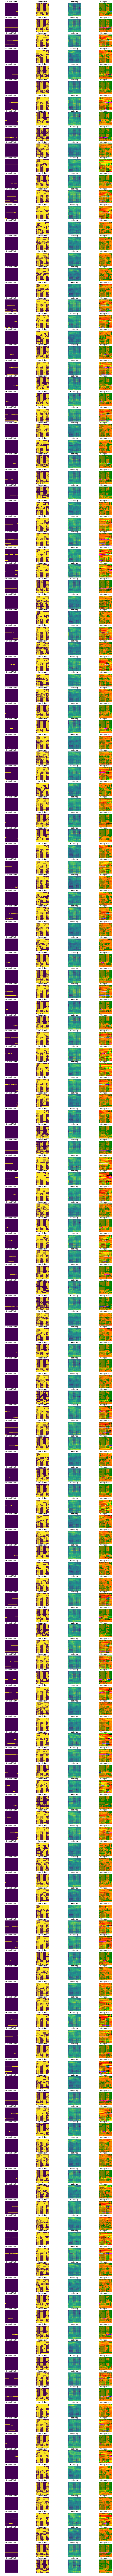

In [14]:
output = autoencoder.predict_proba(test_data, verbose=0)
output = output.reshape((output.shape[0], img_h, img_w, n_labels))

plot_results(output)

In [15]:
import os
import glob
import skimage.io as io
def saveResult(save_path,npyfile,flag_multi_class = False,num_class = 2):
    for i,item in enumerate(npyfile):
        img = labelVisualize(num_class,COLOR_DICT,item) if flag_multi_class else item[:,:,0]
        io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)

In [16]:
saveResult("data/test/",output)

FileNotFoundError: The directory '/home/kshitija/dissertation/keras-segnet-master/data/test' does not exist